# Notebook 11: Topic Modeling Analysis

**Project: Data Triage of Transcribed Nixon Tapes** <br>
*Michelle Ballard and April Crompton* <br>
Loyola University Maryland Data Science Project 

## Import statements

In [1]:
import pickle
from pprint import pprint

import pandas as pd

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import matplotlib.pyplot as plt
%matplotlib inline

import spacy
import seaborn as sns

In [3]:
# unpickle preserved dataframe with segmented exhibits
pkl_file = open('pipelines_chunks.pkl', 'rb')

df_chunks_pipe = pickle.load(pkl_file)
print(df_chunks_pipe.info())

# unpickle preserved coreference dataframe
pkl_file = open('pipelines_coref.pkl', 'rb')

df_coref_pipe = pickle.load(pkl_file)
print(df_coref_pipe.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   corpus           141 non-null    object
 1   exhibit          141 non-null    object
 2   orig_exhibit     141 non-null    object
 3   speech_final     141 non-null    object
 4   named_ent        141 non-null    object
 5   all_ngrams       141 non-null    object
 6   freq_ngrams      141 non-null    object
 7   allgrams         141 non-null    object
 8   NG_text          141 non-null    object
 9   NE_text          141 non-null    object
 10  token_ng         141 non-null    object
 11  token_ne         141 non-null    object
 12  pos_tag_ng       141 non-null    object
 13  lemmatized_ng    141 non-null    object
 14  stemmed_ng       141 non-null    object
 15  pos_tag_ne       141 non-null    object
 16  lemmatized_ne    141 non-null    object
 17  stemmed_ne       141 non-null    ob

## Set up dataset and variables


### Combine datasets for analysis

In [4]:
# ensure consistent indexes
df_chunks_pipe = df_chunks_pipe.set_index(keys=df_chunks_pipe["exhibit"])
display(df_chunks_pipe.sort_index()[80:84])
df_coref_pipe = df_coref_pipe.set_index(keys=df_coref_pipe["exhibit"])
display(df_coref_pipe.sort_index()[80:84])

,corpus,exhibit,orig_exhibit,speech_final,named_ent,all_ngrams,freq_ngrams,allgrams,NG_text,NE_text,...,Pipeline4,Pipeline5,Pipeline6,Pipeline7,Pipeline8,Pipeline9,Pipeline10,Pipeline11,Pipeline12,Pipeline13
exhibit,,,,,,,,,,,,,,,,,,,,,
Part_1_905-008,WSPF,Part_1_905-008,905-008,Hi. Hi. Just to show you somebody still has f...,"[white House, White House, Senate Committee, P...","[damn thing, other thing, national security, w...","[damn thing, other thing, national security, w...","[national security, Attorney General, other th...",Hi. Hi. Just to show you somebody still has f...,Hi. Hi. Just to show you somebody still has f...,...,"[Hi, Hi, Just, to, show, you, somebody, still,...","[somebody, faith, daughter, gardener, lived, c...","[somebodi, faith, daughter, garden, live, cand...","[somebodi, faith, daughter, garden, live, cand...","[somebodi, daughter, garden, candlewood, easte...","[garden, candlewood, president_nixon, bake, ca...","[garden, candlewood, be, be, president_nixon, ...","[daughter, gardener, candlewoods, easter, east...","[daughter, gardener, lived, easter, easter, ba...","[daughter, gardener, lived, easter, easter, ba..."
Part_1_exhibit_12,WG_Trial,Part_1_exhibit_12,exhibit_12,"John, sit down, sit down. Good morning. Well,...","[white House, York City, White House, United S...","[press conference, thousand dollars, other thi...","[press conference, thousand dollars, other thi...","[a mess, Attorney General, campaign laws, wate...","John, sit down, sit down. Good morning. Well,...","John, sit down, sit down. Good morning. Well,...",...,"[John, sit, down, sit, down, Good, morning, We...","[john, sit, sit, good, morning, dean, summary,...","[john, sit, sit, good, morn, dean, summari, da...","[john, sit, sit, good, morn, dean, summari, da...","[morn, summari, the_way, inform, instruct, ins...","[attorney_gener, pat_gray, stubborn, stubborn,...","[not, attorney_gener, have, pat_gray, not, not...","[datum, unwilling, stubborn, stubborn, bullhea...","[proposed, raw_data, unwilling, instruction, s...","[proposed, unwilling, instruction, stubborn, s..."
Part_2_051-001,WSPF,Part_2_051-001,051-001,"Well, another point, Mr. President, is that i...","[South Carolina Kentucky, South Carolina, Orvi...","[thousand dollars, other thing, other things, ...","[thousand dollars, other thing, other things, ...","[the problems, other thing, old story, million...","Well, another_point, Mr._President, is that i...","Well, another point, Mr._President, is that i...",...,"[Well, another_point, Mr_President, is, that, ...","[another_point, mr_president, southeast, dairy...","[another_point, mr_presid, southeast, dairyman...","[another_point, mr_presid, southeast, dairyman...","[another_point, mr_presid, southeast, dairyman...","[mr_presid, southeast, dairyman, brutal, dairy...","[mr_presid, southeast, dairyman, brutal, be, d...","[southeast, dairyman, conscious, inflation, br...","[another_point, southeast, dairymen, conscious...","[southeast, dairymen, conscious, inflation, co..."
Part_2_422-020,WSPF,Part_2_422-020,422-020,What we do with getting information in sort o...,"[white House, White House, Walter Jenkins, Uni...","[press conference, damn thing, other thing, na...","[press conference, damn thing, other thing, na...","[national security, the problems, other thing,...",What we do with getting information in sort o...,What we do with getting information in sort o...,...,"[What, we, do, with, getting, information, in,...","[getting, information, sort, known, strachan, ...","[inform, sort, strachan, bad, fish, fri, low, ...","[inform, sort, strachan, bad, fish, fri, low, ...","[inform, fri, tremend, inform, issu, gordon_st...","[wer, fri, gordon_strachan, john_mitchel, atto...","[go, fri, be, be, not, gordon_strachan, be, jo...","[fry, ordon, haldema, navy, nervous, breakdown...","[fried, navy, breakdown, loaded, ego, pride, a...","[fried, navy, nervous, breakdown, loaded, ego,..."


,corpus,exhibit,orig_exhibit,speech_final,named_ent,all_ngrams,freq_ngrams,allgrams,NG_text,NE_text,...,Pipeline4,Pipeline5,Pipeline6,Pipeline7,Pipeline8,Pipeline9,Pipeline10,Pipeline11,Pipeline12,Pipeline13
exhibit,,,,,,,,,,,,,,,,,,,,,
Part_1_905-008,WSPF,Part_1_905-008,905-008,Hi . Hi . Just to show you somebody still has...,"[white House, White House, Shultz Laird, Senat...","[damn thing, other thing, white house people, ...","[damn thing, other thing, white house people, ...","[public statement, the hell, important thing, ...",Hi . Hi . Just to show you somebody still has...,Hi . Hi . Just to show you somebody still has...,...,"[Hi, Hi, Just, to, show, you, somebody, still,...","[somebody, faith, laird, daughter, gardener, l...","[somebodi, faith, laird, daughter, garden, liv...","[somebodi, faith, laird, daughter, garden, liv...","[somebodi, laird, daughter, garden, candlewood...","[garden, candlewood, president_nixon, bake, ca...","[garden, candlewood, be, be, president_nixon, ...","[laird, daughter, gardener, candlewoods, easte...","[laird, daughter, gardener, lived, easter, eas...","[laird, daughter, gardener, lived, easter, eas..."
Part_1_exhibit_12,WG_Trial,Part_1_exhibit_12,exhibit_12,"John , sit down , sit down . Good morning . W...","[white House, York City, White House, United S...","[press conference, thousand dollars, other thi...","[press conference, thousand dollars, other thi...","[the hell, a lot, good man, York City, that so...","John , sit down , sit down . Good morning . W...","John , sit down , sit down . Good morning . W...",...,"[John, sit, down, sit, down, Good, morning, We...","[john, sit, sit, good, morning, dean, summary,...","[john, sit, sit, good, morn, dean, summari, da...","[john, sit, sit, good, morn, dean, summari, da...","[morn, summari, the_way, inform, instruct, ins...","[attorney_gener, mr, pat_gray, stubborn, stubb...","[not, attorney_gener, pat_gray, not, not, not,...","[datum, unwilling, stubborn, stubborn, bullhea...","[proposed, raw_data, unwilling, instruction, s...","[proposed, unwilling, instruction, stubborn, s..."
Part_2_051-001,WSPF,Part_2_051-001,051-001,"Well , another point , Mr. President , is tha...","[South Carolina Kentucky, South Carolina, Orvi...","[thousand dollars, other thing, other things, ...","[thousand dollars, other thing, other things, ...","[big deal, a lot, the question, main point, li...","Well , another_point , Mr._president , is tha...","Well , another point , Mr._President , is tha...",...,"[Well, another_point, Mr_president, is, that, ...","[another_point, mr_president, southeast, dairy...","[another_point, mr_presid, southeast, dairyman...","[another_point, mr_presid, southeast, dairyman...","[another_point, mr_presid, southeast, dairyman...","[mr_presid, southeast, dairyman, brutal, dairy...","[mr_presid, southeast, dairyman, brutal, m, da...","[southeast, dairyman, conscious, inflation, br...","[another_point, southeast, dairymen, conscious...","[southeast, dairymen, conscious, inflation, co..."
Part_2_422-020,WSPF,Part_2_422-020,422-020,What we do with getting information in sort o...,"[white House, White House, Walter Jenkins, Uni...","[damn thing, press conference, other thing, ot...","[damn thing, press conference, other thing, ot...","[Pat Gray, the hell, watergate business, other...",What we do with getting information in sort o...,What we do with getting information in sort o...,...,"[What, we, do, with, getting, information, in,...","[getting, information, sort, strachan, known, ...","[inform, sort, strachan, strachan, bad, strach...","[inform, sort, strachan, strachan, bad, strach...","[inform, fri, tremend, inform, issu, gordon_st...","[fri, gordon_strachan, john_mitchel, attorney_...","[fri, be, be, not, gordon_strachan, be, john_m...","[fry, ordon, haldema, navy, nervous, breakdown...","[fried, navy, breakdown, loaded, ego, pride, a...","[fried, navy, nervous, breakdown, loaded, ego,..."


In [5]:
df_coref_pipe.rename(columns={"Pipeline8": "Pipeline8c", "Pipeline9": "Pipeline9c", 
                            "Pipeline10": "Pipeline10c", "Pipeline11": "Pipeline11c", 
                            "Pipeline12": "Pipeline12c", "Pipeline13": "Pipeline13c" }, inplace=True)

In [6]:
df_chunks_pipe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141 entries, Part_1_exhibit_12 to 039-083
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   corpus           141 non-null    object
 1   exhibit          141 non-null    object
 2   orig_exhibit     141 non-null    object
 3   speech_final     141 non-null    object
 4   named_ent        141 non-null    object
 5   all_ngrams       141 non-null    object
 6   freq_ngrams      141 non-null    object
 7   allgrams         141 non-null    object
 8   NG_text          141 non-null    object
 9   NE_text          141 non-null    object
 10  token_ng         141 non-null    object
 11  token_ne         141 non-null    object
 12  pos_tag_ng       141 non-null    object
 13  lemmatized_ng    141 non-null    object
 14  stemmed_ng       141 non-null    object
 15  pos_tag_ne       141 non-null    object
 16  lemmatized_ne    141 non-null    object
 17  stemmed_ne       141

In [7]:
df_all_pipes = pd.concat([df_chunks_pipe['orig_exhibit'],df_chunks_pipe['speech_final'],
                          df_chunks_pipe.iloc[:,20:],df_coref_pipe.iloc[:,29:]], axis=1)
df_all_pipes = df_all_pipes.sort_values(by=['orig_exhibit','exhibit'])
display(df_all_pipes.head())
display(df_all_pipes.tail())
df_all_pipes.info()

,orig_exhibit,speech_final,Pipeline0,Pipeline1,lower,Pipeline2,Pipeline3,Pipeline4,Pipeline5,Pipeline6,...,Pipeline10,Pipeline11,Pipeline12,Pipeline13,Pipeline8c,Pipeline9c,Pipeline10c,Pipeline11c,Pipeline12c,Pipeline13c
exhibit,,,,,,,,,,,,,,,,,,,,,
000-000_35d,000-000_35d,"Hello. Hi. How we doin'? Well, uh, about a...","[ , Hello, ., , Hi, ., , How, we, doin', ?, ...","[ , Hello, ., , Hi, ., , How, we, doin', ?, ...","[, hello, ., , hi, ., , how, we, doin', ?, , w...","[hello, ., ., doin', ?, ,, ,, expected, ., ?, ...","[hello, hi, how, we, doin, well, uh, about, as...","[Hello, Hi, How, we, doin, Well, uh, about, as...","[hello, doin, expected, christ, tryin, hold, p...","[hello, expect, christ, tryin, hold, piec, con...",...,"[congratul, be, not, celebr, champagn, not, be...","[tryin, congratulation, victory, celebrity, ch...","[doin, tryin, congratulations, victory, celebr...","[doin, tryin, congratulations, victory, celebr...","[tryin, piec, congratul, victori, victori, sor...","[congratul, celebr, champagn, thingsll, white_...","[congratul, m, not, celebr, champagn, not, be,...","[tryin, congratulation, victory, victory, cele...","[doin, tryin, congratulations, victory, victor...","[doin, tryin, congratulations, victory, victor..."
000-000_37d,000-000_37d,"'Lo! Hi! How are you? I'm, I'm pretty good...","[ , ', Lo, !, , Hi, !, , How, are, you, ?, ...","[ , ', Lo, !, , Hi, !, , How, are, you, ?, ...","[, ', lo, !, , hi, !, , how, are, you, ?, , i,...","[', lo, !, !, ?, ,, pretty, good, ., good, ., ...","[lo, hi, how, are, you, i, m, i, m, pretty, go...","[Lo, Hi, How, are, you, I, m, I, m, pretty, go...","[lo, pretty, good, good, scheduled, tomorrow_a...","[lo, pretti, good, good, schedul, tomorrow_aft...",...,"[lo, be, be, be, be, be, 530, be, obrien, la_r...","[lo, la_rue, divine, enchilada, episode, herb_...","[lo, tomorrow_afternoon, identify, hopes, divi...","[lo, la_rue, identify, cooperated, hopes, divi...","[lo, pretti, schedul, tomorrow_afternoon, juri...","[lo, obrien, obrien, obrien, la_ru, obrien, ob...","[lo, m, m, m, m, m, 530, be, obrien, obrien, o...","[lo, la_rue, divine, enchilada, episode, herb_...","[lo, tomorrow_afternoon, identify, hopes, divi...","[lo, la_rue, identify, cooperated, hopes, divi..."
002-001_002-002,002-001_002-002,"Dick Kleindienst. Thank you, Mr. President. ...","[ , Dick, Kleindienst, ., , Thank, you, ,, Mr...","[ , Dick_Kleindienst, ., , Thank, you, ,, Mr....","[, dick_kleindienst, ., , thank, you, ,, mr._p...","[dick_kleindienst, ., thank, ,, mr._president,...","[dick_kleindienst, thank, you, mr_president, y...","[Dick_Kleindienst, Thank, you, Mr_President, Y...","[dick_kleindienst, thank, mr_president, mr_kle...","[dick_kleindienst, thank, mr_presid, mr_kleind...",...,"[dick_kleindienst, mr_presid, mr_kleindienst, ...","[dick_kleindienst, mr_kleindienst, mclaren, mc...","[dick_kleindienst, mr_kleindienst, general_att...","[dick_kleindienst, mr_kleindienst, mclaren, mc...","[dick_kleindienst, mr_presid, mr_kleindienst, ...","[dick_kleindienst, mr_presid, mr_kleindienst, ...","[dick_kleindienst, mr_presid, mr_kleindienst, ...","[dick_kleindienst, mr_kleindienst, mclaren, mc...","[dick_kleindienst, mr_kleindienst, general_att...","[dick_kleindienst, mr_kleindienst, mclaren, mc..."
037-175_037-176,037-175_037-176,"John Dean, please. Yes, Mr. President. Hel...","[ , John, Dean, ,, please, ., , Yes, ,, Mr., ...","[ , john_Dean, ,, please, ., , Yes, ,, Mr._Pr...","[, john_dean, ,, please, ., , yes, ,, mr._pres...","[john_dean, ,, ., ,, mr._president, ., hello, ...","[john_dean, please, yes, mr_president, hello, ...","[john_Dean, please, Yes, Mr_President, Hello, ...","[john_dean, mr_president, hello, sir, hear, ha...","[john_dean, mr_presid, hello, sir, hear, long,...",...,"[john_dean, mr_presid, not, be, evid, insert, ...","[abandon, insert, insert, countermand, counter...","[abandoned, evidenced, insert, desired, insert...","[abandoned, evidenced, insert, desired, insert...","[john_dea

,orig_exhibit,speech_final,Pipeline0,Pipeline1,lower,Pipeline2,Pipeline3,Pipeline4,Pipeline5,Pipeline6,...,Pipeline10,Pipeline11,Pipeline12,Pipeline13,Pipeline8c,Pipeline9c,Pipeline10c,Pipeline11c,Pipeline12c,Pipeline13c
exhibit,,,,,,,,,,,,,,,,,,,,,
exhibit_14,exhibit_14,"Well, he said, anyway. But you know, he, that...","[ , Well, ,, he, said, ,, anyway, ., But, you,...","[ , Well, ,, he, said, ,, anyway, ., But, you,...","[, well, ,, he, said, ,, anyway, ., but, you, ...","[,, ,, ., ,, ,, probably, typical, ,, ..., sur...","[well, he, said, anyway, but, you, know, he, t...","[Well, he, said, anyway, But, you, know, he, t...","[probably, typical, sure, little_bit, apology,...","[probabl, typic, sure, little_bit, apolog, ses...",...,"[be, apolog, not, reser, be, clue, mu, be, be,...","[apology, reser, clue, mu, superb, bubble, spe...","[apology, reser, channel, clued, mu, superb, f...","[apology, reser, channel, clued, mu, superb, f...","[probabl, typic, little_bit, apolog, reser, on...","[apolog, reser, clue, mu, mr_presid, bubbl, mr...","[be, apolog, not, reser, be, clue, mu, be, be,...","[apology, reser, clue, mu, superb, bubble, spe...","[apology, reser, channel, clued, mu, washingto...","[apology, reser, channel, clued, mu, superb, f..."
exhibit_15,exhibit_15,"Well, the theory, the theory of the Ervin ana...","[ , Well, ,, the, theory, ,, the, theory, of, ...","[ , Well, ,, the, theory, ,, the, theory, of, ...","[, well, ,, the, theory, ,, the, theory, of, t...","[,, theory, ,, theory, ervin, analysis, trying...","[well, the, theory, the, theory, of, the, ervi...","[Well, the, theory, the, theory, of, the, Ervi...","[theory, theory, ervin, analysis, trying, blaz...","[theori, theori, ervin, analysi, tri, blaze, g...",...,"[be, blaze, glori, cheer, eventu, be, not, the...","[blaze, glory, cheerfully, analyzing, bullet, ...","[blaze, glory, cheerfully, analyzing, precisel...","[blaze, glory, cheerfully, analyzing, precisel...","[theori, theori, analysi, tri, blaze, glori, c...","[blaze, glori, cheer, analyzing, eventu, uhand...","[be, blaze, glori, cheer, eventu, be, not, be,...","[blaze, glory, cheerfully, analyzing, bullet, ...","[blaze, glory, cheerfully, analyzing, precisel...","[blaze, glory, cheerfully, analyzing, precisel..."
exhibit_19,exhibit_19,All finished? Yes sir. All finished. He is...,"[ , All, finished, ?, , Yes, sir, ., , All, ...","[ , All, finished, ?, , Yes, sir, ., , All, ...","[, all, finished, ?, , yes, sir, ., , all, fin...","[finished, ?, sir, ., finished, ., innocent, m...","[all, finished, yes, sir, all, finished, he, i...","[All, finished, Yes, sir, All, finished, He, i...","[finished, sir, finished, innocent, man, heart...","[finish, sir, finish, innoc, man, heart, mind,...",...,"[not, admit, systemat, mute, mute, mute, not, ...","[exposure, systematically, mute, mute, mute, l...","[exposure, systematically, mute, mute, mute, r...","[verse, exposure, systematically, mute, mute, ...","[presid, innoc, i_presid, i_presid, an_presid,...","[admit, systemat, mute, mute, mute, reserv, mu...","[not, admit, systemat, mute, mute, mute, not, ...","[exposure, systematically, mute, mute, mute, l...","[exposure, systematically, mute, mute, mute, r...","[verse, exposure, systematically, mute, mute, ..."
exhibit_24,exhibit_24,"John, I want him to, uh, to uh, before I see...","[ , John, ,, I, want, him, to, ,, uh, ,, to, ...","[ , John, ,, I, want, him, to, ,, uh, ,, to, ...","[, john, ,, i, want, him, to, ,, uh, ,, to, uh...","[john, ,, ,, ,, ,, dean, ., tell, ya, really, ...","[john, i, want, him, to, uh, to, uh, before, i...","[John, I, want, him, to, uh, to, uh, before, I...","[john, dean, tell, ya, really, sign, sign, ask...","[john, dean, tell, ya, realli, sign, sign, ask...",...,"[be, be, not, be, be, be, not, be, be, not, pa...","[clipping, whichever, unfolding, pant, plumbin...","[clipping, unfolding, pant, bugs, plumbing, bu...","[clipping, unfolding, pant, bugs, plumbing, bu...","[realli, clip, announ

<class 'pandas.core.frame.DataFrame'>
Index: 141 entries, 000-000_35d to exhibit_37
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   orig_exhibit  141 non-null    object
 1   speech_final  141 non-null    object
 2   Pipeline0     141 non-null    object
 3   Pipeline1     141 non-null    object
 4   lower         141 non-null    object
 5   Pipeline2     141 non-null    object
 6   Pipeline3     141 non-null    object
 7   Pipeline4     141 non-null    object
 8   Pipeline5     141 non-null    object
 9   Pipeline6     141 non-null    object
 10  Pipeline7     141 non-null    object
 11  Pipeline8     141 non-null    object
 12  Pipeline9     141 non-null    object
 13  Pipeline10    141 non-null    object
 14  Pipeline11    141 non-null    object
 15  Pipeline12    141 non-null    object
 16  Pipeline13    141 non-null    object
 17  Pipeline8c    141 non-null    object
 18  Pipeline9c    141 non-null    object
 

### Manually examine processing results

- Pipeline   0
	- Basline - Tokens in a flat list per transcript 
- Pipeline   1
	- N-Grams (NG), Named Entities (NE) defined with an underscore 
- Pipeline   2
	- NG, NE, lowercase (L), remove stopwords (SW) 
- Pipeline   3
	- NG, NE, L, remove punctuation (P) 
- Pipeline  4
	- NG, NE, P  
- Pipeline   5
	- NG, NE, L, SW, P  
- Pipeline  6
	- NG, NE, L, SW, P, lemmatize & stem (S)  
- Pipeline   7
	- NG, NE, L, SW, P, S, remove numbers (N)  
- Pipeline   8
	- NG, NE, L, SW, P, S, N, remove lowest 20% TF-IDF terms weighted across the corpus (I20)  
- Pipeline   9 
	- NE, L, SW, P, S, N, remove lowest 40% TF-IDF terms weighted across the corpus (I40)  
- Pipeline 10
	- NE, L, P, S, I40, remove all parts of speech except nouns, verbs, adjectives, and adverbs  (POS)
- Pipeline 11
	- NE, L, SW, P, S, N, run TFIDF vectorizer on processed text and remove the lowest weighted 20% of processed terms  (I20p) 
- Pipeline 12
	- NG, NE, L, P, S, N, POS, remove misspelled words occurring only once in the dataset (MS), run TFIDF vectorizer on processed text and remove the most frequent 10% of terms and lowest weighted 20% of processed terms  (10I20p)
- Pipeline 13
	- NE, L, P, S, N, POS, MS, 10I20p

In [8]:
# Examine pipelines 
pd.set_option('max_colwidth', 800)
df_all_pipes

,orig_exhibit,speech_final,Pipeline0,Pipeline1,lower,Pipeline2,Pipeline3,Pipeline4,Pipeline5,Pipeline6,...,Pipeline10,Pipeline11,Pipeline12,Pipeline13,Pipeline8c,Pipeline9c,Pipeline10c,Pipeline11c,Pipeline12c,Pipeline13c
exhibit,,,,,,,,,,,,,,,,,,,,,
000-000_35d,000-000_35d,"Hello. Hi. How we doin'? Well, uh, about as can be expected. How are you? Uh, just about the same Christ tryin' to hold the pieces together. Yeah. Congratulations on your victory. Thank you. Uh, you, uh, I'm sorry that uh, we haven't been celebrating it together with some, uh, good champagne and, uh, good scotch, but uh, ... may yet come a time. Who knows It'll come, I assure ya. Let me, uh, let me before you say anything, let me say a couple of things. One, uh, I don't know what's going on here other than, I am told that, uh, uh, everybody's gonna come out all right. That's all I know Uh huh And, uh, I've deliberately not asked any specific questions. Right. For this reason: that, uh, I have my own ideas about how things'll turn out... uh huh. but-and I'm not worri...","[ , Hello, ., , Hi, ., , How, we, doin', ?, , Well, ,, uh, ,, about, as, can, be, expected, ., How, are, you, ?, , Uh, ,, just, about, the, same, Christ, tryin, ', to, hold, the, pieces, together, ., , Yeah, ., Congratulations, on, your, victory, ., , Thank, you, ., , Uh, ,, you, ,, uh, ,, I, 'm, sorry, that, uh, ,, we, have, n't, been, celebrating, it, together, with, some, ,, uh, ,, good, champagne, and, ,, uh, ,, good, scotch, ,, but, uh, ,, ..., , may, yet, come, a, time, ., Who, ...]","[ , Hello, ., , Hi, ., , How, we, doin', ?, , Well, ,, uh, ,, about, as, can, be, expected, ., How, are, you, ?, , Uh, ,, just, about, the, same, Christ, tryin, ', to, hold, the, pieces, together, ., , Yeah, ., Congratulations, on, your, victory, ., , Thank, you, ., , Uh, ,, you, ,, uh, ,, I, 'm, sorry, that, uh, ,, we, have, n't, been, celebrating, it, together, with, some, ,, uh, ,, good, champagne, and, ,, uh, ,, good, scotch, ,, but, uh, ,, ..., , may, yet, come, a, time, ., Who, ...]","[, hello, ., , hi, ., , how, we, doin', ?, , well, ,, uh, ,, about, as, can, be, expected, ., how, are, you, ?, , uh, ,, just, about, the, same, christ, tryin, ', to, hold, the, pieces, together, ., , yeah, ., congratulations, on, your, victory, ., , thank, you, ., , uh, ,, you, ,, uh, ,, i, 'm, sorry, that, uh, ,, we, have, n't, been, celebrating, it, together, with, some, ,, uh, ,, good, champagne, and, ,, uh, ,, good, scotch, ,, but, uh, ,, ..., , may, yet, come, a, time, ., who, ...]","[hello, ., ., doin', ?, ,, ,, expected, ., ?, ,, christ, tryin, ', hold, pieces, ., ., congratulations, victory, ., thank, ., ,, ,, ,, sorry, ,, celebrating, ,, ,, good, champagne, ,, ,, good, scotch, ,, ,, ..., come, time, ., knows, come, ,, assure, ya, ., ,, ,, ,, couple, things, ., ,, ,, ,, told, ,, ,, ,, everybody, gon, na, come, ., ,, ,, 've, deliberately, asked, specific_questions, ., ., reason, :, ,, ,, ideas, things'll, turn, ..., ., -, worried, ‘, em, -, ,, 've, thought, came, ,, ,, open, trial, wanna, free, ,, ...]","[hello, hi, how, we, doin, well, uh, about, as, can, be, expected, how, are, you, uh, just, about, the, same, christ, tryin, to, hold, the, pieces, together, yeah, congratulations, on, your, victory, thank, you, uh, you, uh, i, m, sorry, that, uh, we, have, nt, been, celebrating, it, together, with, some, uh, good, champagne, and, uh, good, scotch, but, uh, may, yet, come, a, time, who, knows, it, ll, come, i, assure, ya, let, me, uh, let, me, before, you, say, anything, let, me, say, a, couple, of, things, one, uh, i, do, nt, know, what, s, going, on, here, ...]","[Hello, Hi, How, we, doin, Well, uh, about, as, can, be, expected, How, are, you, Uh, just, about, the, same, Christ, tryin, to, hold, the, pieces, together, Yeah, Congratulations, on, your, victory, Thank, you, Uh, you, uh, I, m, sorry, that, uh, we, have, nt, been, celebrating, it, together, with, some, uh, good, champagne, and, uh, good, scotch, 

In [9]:
# Extract pipeline names
pipes = [c for c in df_all_pipes.columns if c[:5]=="Pipel"]
pipes

['Pipeline0',
 'Pipeline1',
 'Pipeline2',
 'Pipeline3',
 'Pipeline4',
 'Pipeline5',
 'Pipeline6',
 'Pipeline7',
 'Pipeline8',
 'Pipeline9',
 'Pipeline10',
 'Pipeline11',
 'Pipeline12',
 'Pipeline13',
 'Pipeline8c',
 'Pipeline9c',
 'Pipeline10c',
 'Pipeline11c',
 'Pipeline12c',
 'Pipeline13c']

In [10]:
df_smalls = df_all_pipes[:2]
df_smalls.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, 000-000_35d to 000-000_37d
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   orig_exhibit  2 non-null      object
 1   speech_final  2 non-null      object
 2   Pipeline0     2 non-null      object
 3   Pipeline1     2 non-null      object
 4   lower         2 non-null      object
 5   Pipeline2     2 non-null      object
 6   Pipeline3     2 non-null      object
 7   Pipeline4     2 non-null      object
 8   Pipeline5     2 non-null      object
 9   Pipeline6     2 non-null      object
 10  Pipeline7     2 non-null      object
 11  Pipeline8     2 non-null      object
 12  Pipeline9     2 non-null      object
 13  Pipeline10    2 non-null      object
 14  Pipeline11    2 non-null      object
 15  Pipeline12    2 non-null      object
 16  Pipeline13    2 non-null      object
 17  Pipeline8c    2 non-null      object
 18  Pipeline9c    2 non-null      object
 1

## Feature Extraction

The following features will be needed for LDA models
1. Create an id2word dictionary based on the processed corpus
2. Create a tokenized texts, needed for coherence model
3. Create a corpus of each document bag-of-words (BoW) vectors

In [11]:
def build_id2word(_pipeline, _below, _above):
    id2word = corpora.Dictionary(_pipeline)
    print('id2word before filter:', len(id2word))
    
    # Filter out words that occur less than _below documents, or that occur in more than _above of the documents
    id2word.filter_extremes(no_below=_below, no_above=_above)
    print('id2word after filter:', len(id2word))
    
    return(id2word)

def build_corpus(_id2word, _texts):

    # Create Stream of document vectors
    corpus = [_id2word.doc2bow(doc, allow_update=True) for doc in _texts]
    # Check size of corpus
    print('size of corpus: ', len(corpus))
    
    return(corpus)

### Add parameters to provide additional cleaning

https://radimrehurek.com/gensim/corpora/dictionary.html#

no_below (int, optional) – Keep tokens which are contained in at least no_below documents.

no_above (float, optional) – Keep tokens which are contained in no more than no_above documents (fraction of total corpus size, not an absolute number).

This removes all tokens in the dictionary that are:

1. Less frequent than no_below documents (absolute number, e.g. 5) or
2. More frequent than no_above documents (fraction of the total corpus size, e.g. 0.3).
3. After (1) and (2), keep only the first keep_n most frequent tokens (or keep all if keep_n=None).

In [12]:
# No_below at 20% of corpus length
no_below = int(round(0.2 * (len(df_all_pipes["speech_final"]))))
no_below = no_below+2
no_below

30

In [13]:
%%time
id2word, texts, corpus = {},{},{}
highfilter = (no_below, 0.6)

names = []

for column in pipes:
    name = df_all_pipes[column].name           ### df_smalls[column].name    
    names.append(name)
    print('\n~~~{}:~~~'.format(name))   
    texts[name] = df_all_pipes[column].values   ### df_smalls[column].values 
    id2word[name] = build_id2word(texts[name], highfilter[0], highfilter[1])
    corpus[name] = build_corpus(id2word[name], texts[name])


~~~Pipeline0:~~~
id2word before filter: 14100
id2word after filter: 607
size of corpus:  141

~~~Pipeline1:~~~
id2word before filter: 15126
id2word after filter: 611
size of corpus:  141

~~~Pipeline2:~~~
id2word before filter: 12547
id2word after filter: 487
size of corpus:  141

~~~Pipeline3:~~~
id2word before filter: 11893
id2word after filter: 547
size of corpus:  141

~~~Pipeline4:~~~
id2word before filter: 13338
id2word after filter: 595
size of corpus:  141

~~~Pipeline5:~~~
id2word before filter: 11430
id2word after filter: 478
size of corpus:  141

~~~Pipeline6:~~~
id2word before filter: 8063
id2word after filter: 423
size of corpus:  141

~~~Pipeline7:~~~
id2word before filter: 7750
id2word after filter: 424
size of corpus:  141

~~~Pipeline8:~~~
id2word before filter: 6849
id2word after filter: 169
size of corpus:  141

~~~Pipeline9:~~~
id2word before filter: 5932
id2word after filter: 16
size of corpus:  141

~~~Pipeline10:~~~
id2word before filter: 5741
id2word after filt

## LDA Modeling

Build LDA_models and iterate through a range of topics.  

Leveraged the `LdaModel` instead of `LdaMulticore` model because the ability to set `alpha` to `'auto'` is not available in the distributed multicore model.  This parameter made a significant difference in coherence results. The `alpha` represents document to topic density, and allowing the `'auto'` parameter, the model learned an asymmetric prior from the corpus.

Resources on LDA model
*   https://papers.neurips.cc/paper/2010/file/1f6278d140af599e06ad9bf1ba03cb0-Paper.pdf
*   https://radimrehurek.com/gensim/models/ldamodel.html


**Default values of parameters available:**
*classgensim.models.ldamodel.LdaModel(corpus=None, num_topics=100, id2word=None, distributed=False, chunksize=2000, passes=1, update_every=1, alpha='symmetric', eta=None, decay=0.5, offset=1.0, eval_every=10, iterations=50, gamma_threshold=0.001, minimum_probability=0.01, random_state=None, ns_conf=None, minimum_phi_value=0.01, per_word_topics=False, callbacks=None, dtype=<class 'numpy.float32'>)*

In [14]:
%%time

# Run through a series of models to pick the best number of topics
num_topics = list(range(1,21,2)[1:])  #list(range(5,31,5)[1:])  ############# UPDATED TO 15
num_keywords = 20

LDA_models = {}
LDA_topics = {}
coherences = {}
u_mass = {}

for pipeline_name in names:
    name = pipeline_name
    
    
    for i in num_topics:
        modelname = name + '_topics' + str(i)
        print(modelname)
        LDA_models[modelname] = gensim.models.LdaModel(corpus=corpus[name],
                                 id2word=id2word[name],
                                 num_topics=i,
                                 update_every=1,
                                 iterations=50,
                                 chunksize=1000,
                                 passes=30,
                                 alpha='auto',
                                 eta='auto',
                                 random_state=42,
                                 per_word_topics=True)

        shown_topics = LDA_models[modelname].show_topics(num_topics=i, 
                                                 num_words=num_keywords,
                                                 formatted=False)

        LDA_topics[modelname] = [[word[0] for word in topic[1]] for topic in shown_topics]
        
        # Gather coherences from the LDA models run
        coherences[modelname] = CoherenceModel(model=LDA_models[modelname], texts=texts[name], dictionary=id2word[name], coherence='c_v').get_coherence()
        pprint(coherences[modelname])
        
        # Gather coherences from the LDA models run
        u_mass[modelname] = CoherenceModel(model=LDA_models[modelname], corpus=corpus[name], dictionary=id2word[name], coherence='u_mass').get_coherence()
        pprint(u_mass[modelname])

Pipeline0_topics3
0.23112501692055176
-0.24267063238355469
Pipeline0_topics5
0.20254988747028824
-0.02437437403949575
Pipeline0_topics7
0.23018326449802382
-0.22168451927451535
Pipeline0_topics9
0.22165250343787957
-0.20148906383744877
Pipeline0_topics11
0.21265842881131702
-0.1855554921560903
Pipeline0_topics13
0.22452583442408702
-0.10325805498571822
Pipeline0_topics15
0.20087003428890074
-0.01620919605624611
Pipeline0_topics17
0.20112409534301018
-0.01735792428573263
Pipeline0_topics19
0.2015899530977588
-0.01826710992788993
Pipeline1_topics3
0.20662776299105132
-0.01888271423374197
Pipeline1_topics5
0.2068922685039984
-0.04327889513823123
Pipeline1_topics7
0.2484879962546836
-0.1754921410747667
Pipeline1_topics9
0.20519205091774675
-0.018124707725624786
Pipeline1_topics11
0.2231697917010852
-0.14987188455425143
Pipeline1_topics13
0.20743745065020852
-0.07034736534016978
Pipeline1_topics15
0.20557752145525718
-0.036294630743066755
Pipeline1_topics17
0.25402227016557205
-0.2748378897

### Model Performance Evaluation

Based on "Exploring the Space of Topic Coherence Measures," that provided insight into how various topic coherence meausures correlated to human topic coherence ratings (Michael Roder, 2015).  The paper found that coherence measures based on pointwise mutual information (PMI) gave the largest correlations with human ratings. Below are the two measures from this paper that will be used to evaluate the models performance chosen for effectiveness and efficiency.

1. **c_v**: A combination of the indirect cosine measure with the normalized PMI and boolean sliding window.  This coherence measure had the strongest correlations with human ratings, however it takes longer to compute.

2. **u_mass**: Measures the joint probability of two words seen together in the corpus.  This measure has lower correlations to human ratings, especially when the dataset is small, however the runtimes are much faster.

The evaluation will leverage the CoherenceModel pipeline from gensim. 

In [15]:
# Generate score metrics dataframes

df_coherences = pd.DataFrame(coherences.items(),  columns=['Pipeline', 'Coherence_Values'])
df_coherences[['Pipeline', 'Topics']] = df_coherences['Pipeline'].str.split('_topics', expand=True)
df_coherences['Topics'] = df_coherences['Topics'].astype('int')


df_umass = pd.DataFrame(u_mass.items(),  columns=['Pipeline', 'U_Mass_Values'])
df_umass[['Pipeline', 'Topics']] = df_umass['Pipeline'].str.split('_topics', expand=True)
df_umass['Topics'] = df_umass['Topics'].astype('int')

In [16]:
highest_val_u = df_umass['U_Mass_Values'].idxmin()
highest_val_u
df_umass.iloc[highest_val_u]

Pipeline         Pipeline11c
U_Mass_Values     -19.273271
Topics                     3
Name: 153, dtype: object

In [17]:
highest_val_c = df_coherences['Coherence_Values'].idxmax()
highest_val_c
df_coherences.iloc[highest_val_c]

Pipeline            Pipeline12c
Coherence_Values       0.685036
Topics                        3
Name: 162, dtype: object

In [18]:
# build a hm dataframe for coherences
hm_coherences = pd.pivot_table(df_coherences, index='Topics', columns='Pipeline', values = 'Coherence_Values')
hm_coherences = hm_coherences.reindex(columns=pipes)
hm_coherences = hm_coherences.T
hm_coherences

Topics,3,5,7,9,11,13,15,17,19
Pipeline,,,,,,,,,
Pipeline0,0.231125,0.202550,0.230183,0.221653,0.212658,0.224526,0.200870,0.201124,0.201590
Pipeline1,0.206628,0.206892,0.248488,0.205192,0.223170,0.207437,0.205578,0.254022,0.217334
Pipeline2,0.289162,0.293991,0.238284,0.254989,0.258512,0.272192,0.296288,0.289407,0.308395
Pipeline3,0.207897,0.222017,0.265197,0.240616,0.255677,0.295170,0.216428,0.271831,0.266454
Pipeline4,0.211276,0.210833,0.210925,0.236664,0.210004,0.233078,0.211489,0.208083,0.220425
Pipeline5,0.273531,0.281248,0.259583,0.267635,0.320742,0.283089,0.284684,0.265549,0.280122
Pipeline6,0.275208,0.265841,0.292627,0.276424,0.257965,0.269022,0.295803,0.294146,0.298064
Pipeline7,0.250351,0.257949,0.270571,0.301464,0.263440,0.299296,0.283673,0.285940,0.282892
Pipeline8,0.258949,0.261388,0.265024,0.274491,0.302655,0.285827,0.276700,0.289472,0.305313


In [19]:
# build a hm datafrom for umass
hm_umass = pd.pivot_table(df_umass, index='Topics', columns='Pipeline', values = 'U_Mass_Values')
hm_umass = hm_umass.reindex(columns=pipes)
hm_umass = hm_umass.T
hm_umass

Topics,3,5,7,9,11,13,15,17,19
Pipeline,,,,,,,,,
Pipeline0,-0.242671,-0.024374,-0.221685,-0.201489,-0.185555,-0.103258,-0.016209,-0.017358,-0.018267
Pipeline1,-0.018883,-0.043279,-0.175492,-0.018125,-0.149872,-0.070347,-0.036295,-0.274838,-0.209022
Pipeline2,-2.300598,-0.691491,-0.148922,-0.560051,-0.241212,-0.397116,-0.332706,-0.360703,-0.356476
Pipeline3,-0.014640,-0.066656,-0.082842,-1.099725,-0.203506,-0.312475,-0.250453,-1.400544,-0.594871
Pipeline4,-0.012927,-0.016820,-0.017942,-0.187419,-0.016256,-0.110496,-0.040536,-0.014536,-0.054985
Pipeline5,-0.258280,-0.742605,-0.304952,-0.402084,-0.625882,-0.378753,-0.615848,-0.334825,-0.452872
Pipeline6,-0.249541,-0.284124,-0.366957,-0.705579,-0.429536,-0.454201,-0.474817,-0.383502,-0.565944
Pipeline7,-0.318295,-0.260596,-0.795388,-0.477478,-0.305401,-1.169905,-1.043005,-1.144662,-0.410618
Pipeline8,-0.245953,-0.353715,-0.468680,-0.601774,-0.721899,-0.689514,-0.484690,-0.800424,-0.670733


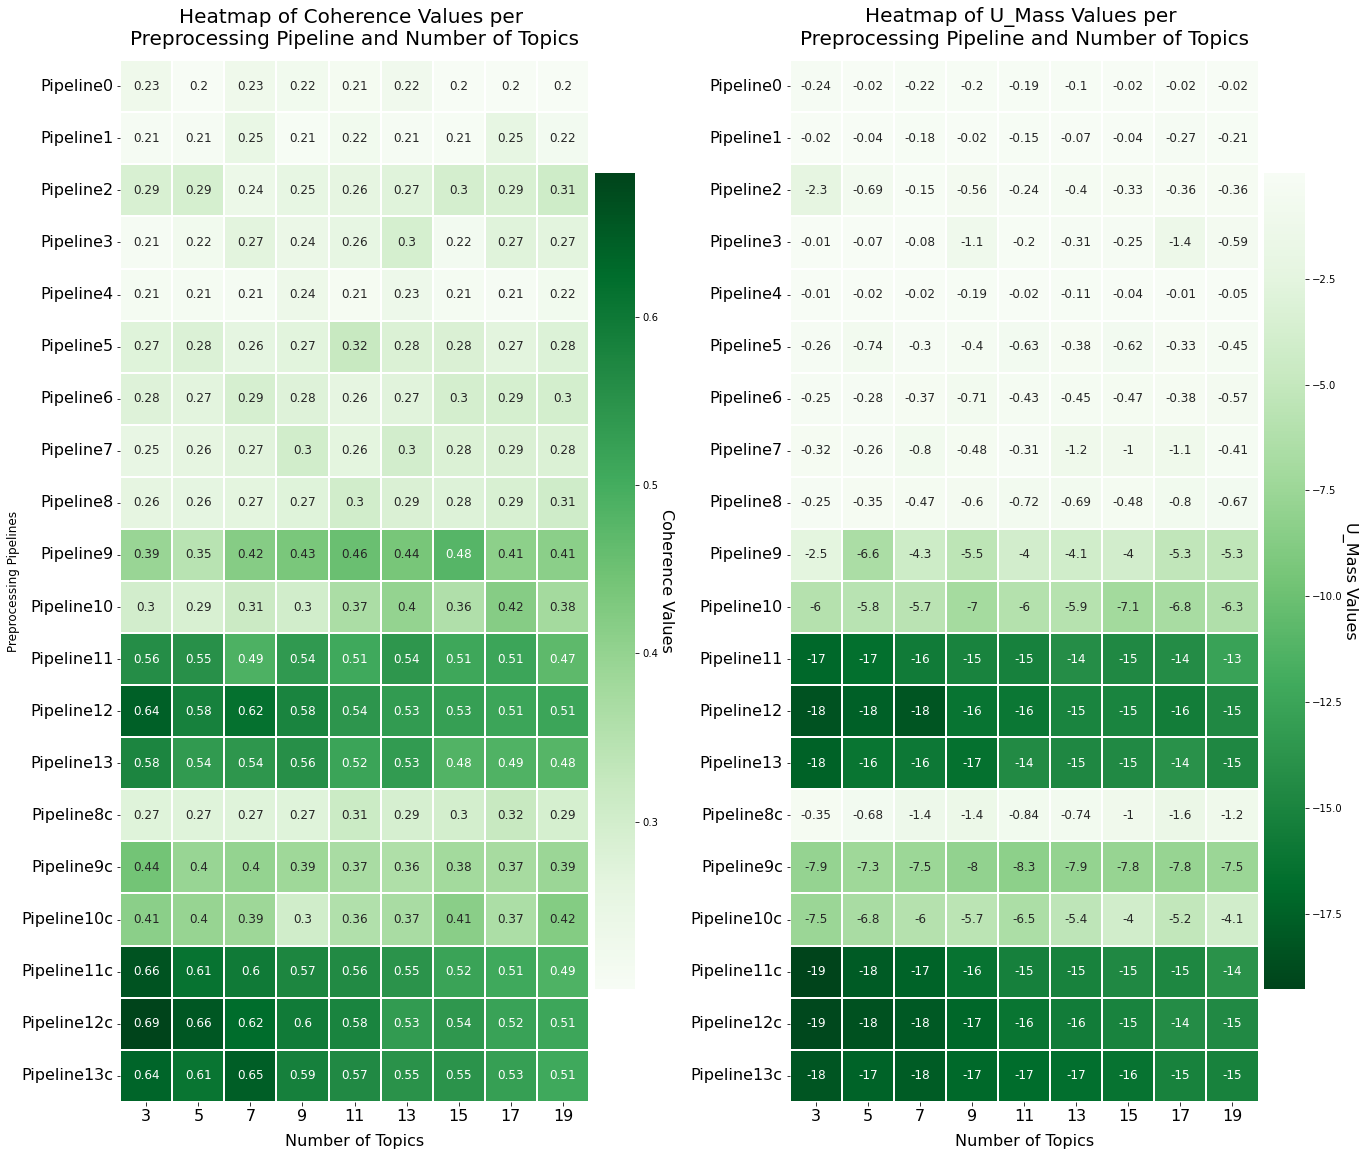

In [20]:


fig = plt.figure(figsize=(22,20))
ax = fig.add_subplot(1,2,1)

ax1 = sns.heatmap(hm_coherences, linewidth=0.2, annot = True, cmap = 'Greens',
                 square = True, annot_kws={'size':12},
                 cbar_kws={'orientation':'vertical', "shrink": .75, "pad":0.01})

plt.title('Heatmap of Coherence Values per \nPreprocessing Pipeline and Number of Topics', fontsize=20, pad=15)
plt.xlabel('Number of Topics', fontsize=16, labelpad=10)
plt.ylabel('Preprocessing Pipelines', fontsize=12, labelpad=1)
plt.yticks(rotation=0, size=16)
plt.xticks(size=16)

cbar = ax1.collections[0].colorbar

cbar.set_label('Coherence Values', rotation=270, fontsize=16, color='black', labelpad=16)


ax2 = fig.add_subplot(1,2,2)

ax2 = sns.heatmap(round(hm_umass,2), linewidth=0.2, annot = True, cmap = 'Greens_r',
                 square = True, annot_kws={'size':12},
                 cbar_kws={'orientation':'vertical', "shrink": .75, "pad":0.01})

plt.title('Heatmap of U_Mass Values per \nPreprocessing Pipeline and Number of Topics', fontsize=20, pad=15)
plt.xlabel('Number of Topics', fontsize=16, labelpad=10)
plt.ylabel('')#Preprocessing Pipeline', fontsize=14, labelpad=1)
plt.yticks(rotation=0, size=16)
plt.xticks(size=16)

cbar = ax2.collections[0].colorbar

cbar.set_label('U_Mass Values', rotation=270, fontsize=16, color='black', labelpad=16)

plt.show();

## Determined Winner from heatmap: Pipeline13c, with 7 Topics

## Pickle LDA results data

In [21]:
# Pickle LDA data
output = open('LDA_data.pkl', 'wb')

pickle.dump( LDA_models, output )
pickle.dump( LDA_topics, output )
pickle.dump( coherences, output )
pickle.dump( u_mass, output )
pickle.dump( id2word, output )
pickle.dump( texts, output )
pickle.dump( corpus, output )

# unpickle preserved dataframe with segmented exhibits
#pkl_file = open('pipelines_chunks.pkl', 'rb')
# pickle reduced dataframe to reduce upload size

#sys.setrecursionlimit(100000)

#pickle.dump(df_collab, output)

output.close()